In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense,Dropout, Flatten,LSTM,RepeatVector,TimeDistributed,Conv1D,MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from livelossplot.keras import PlotLossesCallback

from statsmodels.tsa.seasonal import seasonal_decompose

Using TensorFlow backend.


In [2]:
df = pd.read_csv("new_housing.csv")
neighborhoods = ['Logan Square']
df_neighborhood = df[df.RegionName.isin(neighborhoods)]
df_neighborhood.head()

,Unnamed: 0,RegionName,variable,value
0,0,Logan Square,1997-01,146203.0
209,209,Logan Square,1997-02,147431.0
418,418,Logan Square,1997-03,147053.0
627,627,Logan Square,1997-04,146215.0
836,836,Logan Square,1997-05,146558.0


# Data Preparation

For simplicity, we consider fixed length sequences at training time. We use the past 24 months to forecast the following 12 months.

In [3]:
def train_test_builder(df_neighborhood,size_test=24,length_train_sequence = 24,length_forecast = 12, normalize = False):
    
    train_df = df_neighborhood[:-size_test]    
    print(train_df)
    # create training sets
    train_x,train_y = window_splitter(train_df)
    
    # create test set
    tmp = df_neighborhood[:length_forecast]
    tmp = pd.concat([df,tmp],ignore_index = True)
    tmp[-length_forecast:] = np.nan  # unknown
    test_x,test_y = window_splitter(tmp)
    # drop elements in training
    test_x = test_x[train_x.shape[0]:]
    test_y = test_y[train_x.shape[0]:]
    for i in range(length_forecast):
        test_y[i,:(11-i)]=np.nan # present in training_set
    
    # normalize
    if normalize:
        m = train_df.value.mean()
        sd = train_df.value.std()
        train_x -= m
        train_x/= sd
        test_x -=m
        test_x /= sd
    
    return train_x,train_y,test_x,test_y


# iterate over the time steps and divide the data into overlapping windows; 
def window_splitter(train_df,length_train_sequence = 24,length_forecast = 12):
    i = 0
    x,y = [],[]
    while i + length_train_sequence+ length_forecast < len(train_df):
        x.append(train_df.value[i:(i+length_train_sequence)].values)
        y.append(train_df.value[(i+length_train_sequence):(i+length_train_sequence+length_forecast)].values)
        i+=1

    x = np.array(x).reshape(-1,length_train_sequence,1)
    y = np.array(y).reshape(-1,length_forecast)
    
    return x,y

In [4]:
# build both versions

train_x,train_y,test_x,test_y = train_test_builder(df_neighborhood)

train_x.shape, train_y.shape, test_x.shape, test_y.shape

       Unnamed: 0    RegionName variable     value
0               0  Logan Square  1997-01  146203.0
209           209  Logan Square  1997-02  147431.0
418           418  Logan Square  1997-03  147053.0
627           627  Logan Square  1997-04  146215.0
836           836  Logan Square  1997-05  146558.0
1045         1045  Logan Square  1997-06  147291.0
1254         1254  Logan Square  1997-07  148091.0
1463         1463  Logan Square  1997-08  147456.0
1672         1672  Logan Square  1997-09  146908.0
1881         1881  Logan Square  1997-10  146246.0
2090         2090  Logan Square  1997-11  145943.0
2299         2299  Logan Square  1997-12  146264.0
2508         2508  Logan Square  1998-01  145494.0
2717         2717  Logan Square  1998-02  144750.0
2926         2926  Logan Square  1998-03  143770.0
3135         3135  Logan Square  1998-04  144844.0
3344         3344  Logan Square  1998-05  145809.0
3553         3553  Logan Square  1998-06  146816.0
3762         3762  Logan Square

((216, 24, 1), (216, 12), (57444, 24, 1), (57444, 12))

# Evaluation

In [5]:
# evaluation function
def evaluate_predictions(pred_y, test_y):
    return pd.DataFrame(abs(test_y-pred_y)).mean(skipna = True)


def plot_evaluation(pred_y,test_y,n=12):
    scores = evaluate_predictions(pred_y,test_y)

    print("Mean absolute error test set:",scores.mean())

    plt.figure(figsize=(6,4))
    plt.plot(np.arange(1,13),scores)
    plt.xticks(np.arange(1,13))
    plt.xlabel("horizon [months]", size = 15)
    plt.ylabel("MAE", size = 15)
    plt.title("Scores LSTM on test set")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.title("LSTM forecasting - test set window")
    plt.plot(np.arange(1,13),pred_y[n:(n+1)].reshape(-1,1),label = "predictions")
    plt.plot(np.arange(1,13),test_y[n:(n+1)].reshape(-1,1),label = "true values")
    plt.xticks(np.arange(1,13))
    plt.xlabel("horizon [months]", size = 15)
    plt.legend()
    plt.show()

# LSTM 

In [6]:
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

# define model
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(None, 1), return_sequences = True))
model.add(LSTM(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(n_outputs))

# compile
model.compile(loss='mse', optimizer= Adam(lr=1e-3), metrics = ["mae"])

# callbacks
early_stopping = EarlyStopping(patience=32, monitor='val_loss', mode='auto', restore_best_weights=True)
callbacks=[PlotLossesCallback(), early_stopping]

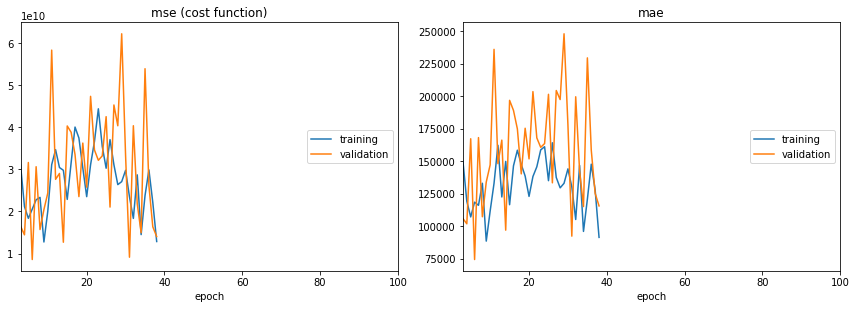

mse (cost function):
training   (min: 12761868240.372, max: 50555722418.605, cur: 12873941789.767)
validation (min: 8605915322.182, max: 62140085341.091, cur: 14042946373.818)

mae:
training   (min: 88431.859, max: 203548.766, cur: 91304.047)
validation (min: 74265.180, max: 247999.438, cur: 115527.883)


In [7]:
# fit network
model.fit(train_x, train_y, 
          validation_split = 0.2, 
          epochs=100, 
          shuffle = False,
          batch_size=16,
          verbose=1,
          callbacks = callbacks,
         )

In [8]:
# predict test set
pred_y = model.predict(test_x)
# add seasonality of the past year


Mean absolute error test set: 141958.0141535029


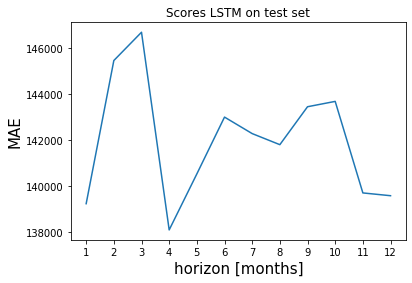

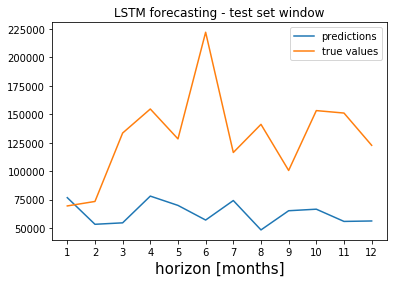

In [9]:
plot_evaluation(pred_y,test_y,n=12)

In [15]:
from sklearn.metrics import mean_squared_error, r2_score

# Score the predictions with mse and r2
mse = mean_squared_error(test_y, pred_y)
r2 = r2_score(test_y, pred_y)
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ){r2}")

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# store predictions on test set
tmp = pd.DataFrame(test_y-pred_y)
tmp.columns = np.arange(1,13)

tmp.to_csv("lstm_predictions.csv",index = False)